In [1]:
%pip install pandas numpy opencv-python matplotlib imbalanced-learn kaggle


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


C:\Users\Ibrahim Aejaz\miniconda3\envs\tf-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download & unzip into a local folder called "alzheimer_data"
api.dataset_download_files(
    'marcopinamonti/alzheimer-mri-4-classes-dataset',
    path='alzheimer_data',   # <-- use `path=`, not `download_path=`
    unzip=True
)

print("Files are now available under ./alzheimer_data/")


Dataset URL: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset
Files are now available under ./alzheimer_data/


In [6]:
# Extra  Test Cases 
%pip install scikit-learn seaborn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import shutil
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# 1) Authenticate & download via Kaggle API into ./alzheimer_raw
api = KaggleApi()
api.authenticate()
download_dir = "alzheimer_raw"
api.dataset_download_files(
    'marcopinamonti/alzheimer-mri-4-classes-dataset',
    path=download_dir,
    unzip=False  # we'll unzip ourselves so we know the zip filename
)

# 2) Find the ZIP file that was just downloaded
zip_files = [f for f in os.listdir(download_dir) if f.endswith('.zip')]
if len(zip_files) != 1:
    raise RuntimeError(f"Expected exactly 1 .zip in {download_dir}, found {zip_files}")
zip_path = os.path.join(download_dir, zip_files[0])
print("→ Downloaded ZIP:", zip_path)

# 3) Unzip into a staging folder
extract_root = "alzheimers-staging"
os.makedirs(extract_root, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_root)
print("→ Extracted to:", extract_root)

# 4) Identify where the class subfolders actually live
#    (adjust this if needed based on your unzip structure)
#    Commonly it will be something like:
possible = os.path.join(extract_root, "Alzheimer_MRI_4_classes_dataset")
if os.path.isdir(possible):
    actual_data_dir = possible
else:
    actual_data_dir = extract_root

print("→ Using data directory:", actual_data_dir)
print("   Contains:", os.listdir(actual_data_dir))

# 5) Copy the class folders into your final ./dataset folder
work_dir = "dataset"
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)
shutil.copytree(actual_data_dir, work_dir)
print("✅ dataset/ ready!  Classes:", os.listdir(work_dir))


Dataset URL: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset
→ Downloaded ZIP: alzheimer_raw\alzheimer-mri-4-classes-dataset.zip
→ Extracted to: alzheimers-staging
→ Using data directory: alzheimers-staging\Alzheimer_MRI_4_classes_dataset
   Contains: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
✅ dataset/ ready!  Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [9]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.10.0
Num GPUs Available: 1


In [10]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [11]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [12]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)


Found 6400 images belonging to 4 classes.


## Visualization

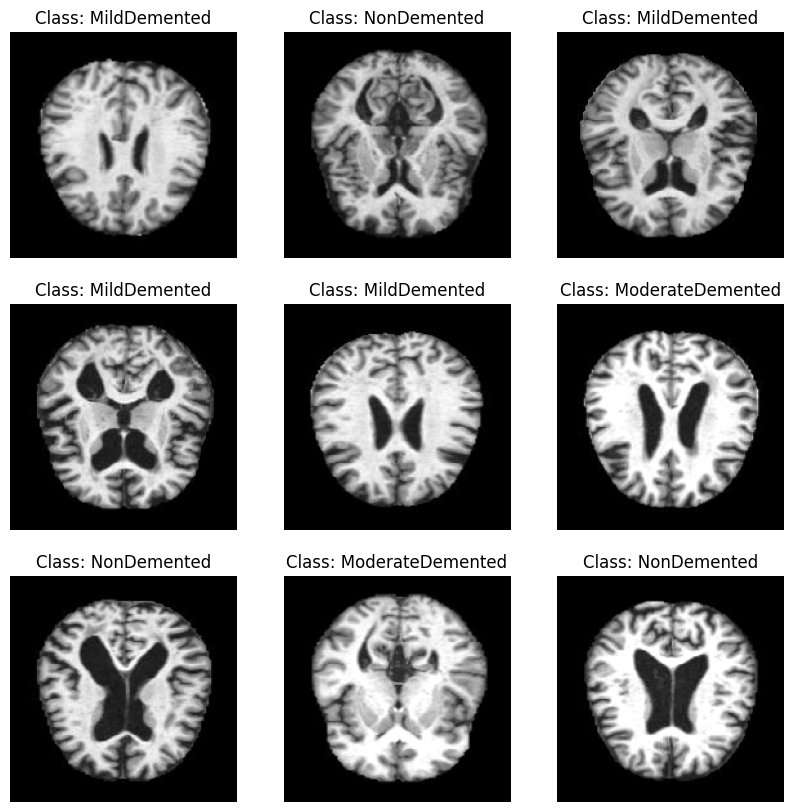

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

def show_images(generator, y_pred=None):
    # assuming you have something like
    # CLASSES = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']
    labels = dict(zip(range(len(CLASSES)), CLASSES))

    # grab one batch from the generator
    x, y = next(generator)

    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, x.shape[0] - 1)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title(f"Class: {labels[np.argmax(y[idx])]}")
    else:
        # if you passed in predictions, show actual vs predicted
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title(
                f"Actual: {labels[np.argmax(y[i])]}\n"
                f"Predicted: {labels[y_pred[i]]}"
            )

# Usage
show_images(train_dataset)


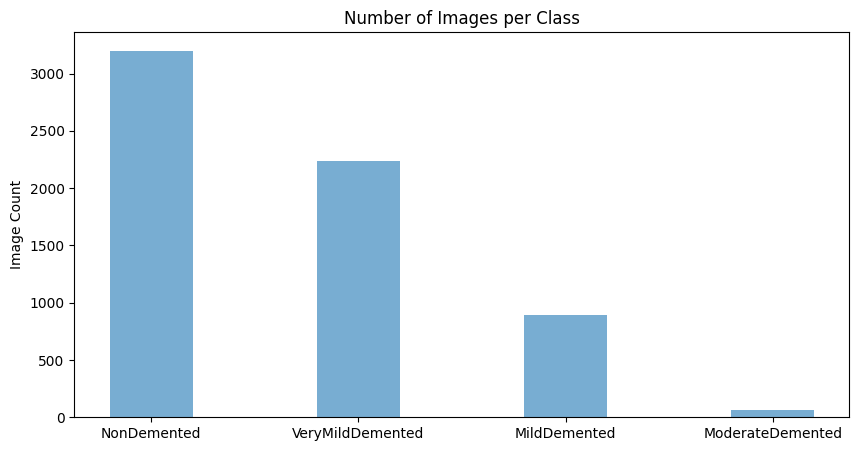

In [14]:
import os
import matplotlib.pyplot as plt

# Point this at wherever your images actually live
work_dir = "./dataset"

# Initialize counts for each class
data = {
    'NonDemented':      0,
    'VeryMildDemented': 0,
    'MildDemented':     0,
    'ModerateDemented': 0
}

# Walk only the directories you care about
for cls in os.listdir(work_dir):
    if cls not in data:
        continue

    cls_path = os.path.join(work_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    # Count only the files (images) in that folder
    num_images = len([
        f for f in os.listdir(cls_path)
        if os.path.isfile(os.path.join(cls_path, f))
    ])
    data[cls] = num_images

# Plot the bar chart
keys   = list(data.keys())
values = list(data.values())

plt.figure(figsize=(10, 5))
plt.bar(keys, values, width=0.4, alpha=0.6)
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.show()


## Feature Engineering and Oversampling

In [15]:
# instead of
# train_data, train_labels = train_dataset.next()

# do this
train_data, train_labels = next(train_dataset)


In [16]:
print(train_data.shape, train_labels.shape)

(1200, 176, 176, 3) (1200, 4)


In [17]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
import os

# --- (A) Load the entire dataset ---
# We'll use image_dataset_from_directory to load the dataset
# Adjust batch size to load all data, or load iteratively if memory is an issue.
# A large batch size like the total number of images is fine if you intend to load everything.

# First, count the total number of images to set the batch size appropriately
total_images = 0
print(f"Checking directory: {work_dir}") # Add print to check the directory being processed
if os.path.exists(work_dir):
    for cls in os.listdir(work_dir):
        cls_path = os.path.join(work_dir, cls)
        # Add print to check the class directory being processed
        print(f"Checking class directory: {cls_path}")
        if os.path.isdir(cls_path):
            # Add print to show files found in the class directory
            files_in_cls = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
            print(f"Found {len(files_in_cls)} files in {cls_path}")
            num_images = len(files_in_cls)
            total_images += num_images
else:
    print(f"Error: Directory not found: {work_dir}")

print(f"Total images found: {total_images}")

# Add a check to ensure total_images is not zero before creating the dataset
if total_images == 0:
    print("Error: No images found in the dataset directory. Please check the directory path and contents.")
else:
    # Now load the dataset using image_dataset_from_directory
    # We'll set the batch size to the total number of images to get one batch with all data
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=work_dir,
        labels='inferred', # labels are inferred from directory names
        label_mode='categorical', # one-hot encoding
        image_size=(IMG_SIZE, IMG_SIZE),
        interpolation='nearest',
        batch_size=total_images, # Load the entire dataset in one batch
        shuffle=False # No need to shuffle if loading everything
    )

    # --- (B) Extract data and labels from the dataset ---
    # image_dataset_from_directory returns a dataset of batches. Since our batch_size is
    # total_images, there is only one batch. We can get this batch.
    for images, labels in full_dataset:
        train_data = images.numpy()
        train_labels = labels.numpy()
        break # Stop after getting the first and only batch

    # --- (C) Apply rescale (and other augmentations if desired) ---
    # The images loaded are in the range [0, 255]. We need to rescale them to [0, 1].
    # You can also apply other transformations if you want to augment *before* SMOTE,
    # but often augmentation is done *after* SMOTE or during training.
    train_data = train_data / 255.0

    print(f"Shape of loaded data: {train_data.shape}")
    print(f"Shape of loaded labels: {train_labels.shape}")

    # --- (D) Apply SMOTE ---
    # Your original SMOTE code seems correct for the numpy arrays once you have them all.
    # Resampling data

    sm = SMOTE(random_state=42)

    # Convert one-hot encoded labels to categorical labels
    # Find the index of the maximum value in each row to get the class index
    train_labels_categorical = np.argmax(train_labels, axis=1)

    # Reshape train_data for SMOTE
    # Make sure train_data is numpy array (which it is after .numpy())
    train_data_reshaped = train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

    # Apply SMOTE with the categorical labels
    # SMOTE requires at least 2 classes, which you should have now that you loaded the full dataset.
    train_data_resampled, train_labels_resampled = sm.fit_resample(train_data_reshaped, train_labels_categorical)

    # Reshape the resampled data back to image format
    train_data = train_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    # Convert the resampled categorical labels back to one-hot encoding if needed for subsequent steps (like training the CNN)
    num_classes = train_labels.shape[1] # Get the number of classes from the original one-hot encoded labels
    train_labels = keras.utils.to_categorical(train_labels_resampled, num_classes=num_classes)

    print("\nShape after SMOTE:")
    print(train_data.shape, train_labels.shape)

Checking directory: ./dataset
Checking class directory: ./dataset\MildDemented
Found 896 files in ./dataset\MildDemented
Checking class directory: ./dataset\ModerateDemented
Found 64 files in ./dataset\ModerateDemented
Checking class directory: ./dataset\NonDemented
Found 3200 files in ./dataset\NonDemented
Checking class directory: ./dataset\VeryMildDemented
Found 2240 files in ./dataset\VeryMildDemented
Total images found: 6400
Found 6400 files belonging to 4 classes.
Shape of loaded data: (6400, 176, 176, 3)
Shape of loaded labels: (6400, 4)


C:\Users\Ibrahim Aejaz\miniconda3\envs\tf-gpu\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Ibrahim Aejaz\miniconda3\envs\tf-gpu\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Ibrahim Aejaz\miniconda3\envs\tf-gpu\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Ibrahim Aejaz\miniconda3\envs\tf-gpu\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Ibrahim Aejaz\miniconda3\envs\tf-gpu\lib\subprocess.py", line 1327, in _execute_child
    


Shape after SMOTE:
(12800, 176, 176, 3) (12800, 4)


In [18]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## CNN

In [19]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

In [20]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [21]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
256/256 [==============================] - 22s 35ms/step - loss: 1.5847 - acc: 0.3492 - auc: 0.6098 - val_loss: 1.4742 - val_acc: 0.2422 - val_auc: 0.5003
Epoch 2/50
256/256 [==============================] - 7s 28ms/step - loss: 1.0417 - acc: 0.5389 - auc: 0.8062 - val_loss: 1.8039 - val_acc: 0.2988 - val_auc: 0.5357
Epoch 3/50
256/256 [==============================] - 7s 28ms/step - loss: 0.7461 - acc: 0.6567 - auc: 0.8969 - val_loss: 4.3300 - val_acc: 0.2402 - val_auc: 0.5480
Epoch 4/50
256/256 [==============================] - 8s 30ms/step - loss: 0.6696 - acc: 0.6936 - auc: 0.9164 - val_loss: 3.6854 - val_acc: 0.2422 - val_auc: 0.6451
Epoch 5/50
256/256 [==============================] - 7s 28ms/step - loss: 0.5841 - acc: 0.7385 - auc: 0.9373 - val_loss: 3.2153 - val_acc: 0.4951 - val_auc: 0.6943
Epoch 6/50
256/256 [==============================] - 7s 28ms/step - loss: 0.5311 - acc: 0.7639 - auc: 0.9479 - val_loss: 7.4157 - val_acc: 0.2446 - val_auc: 0.5839
Epoch 7/5

In [22]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

80/80 [==============================] - 2s 24ms/step - loss: 0.2784 - acc: 0.9141 - auc: 0.9859
Loss:  0.2783733010292053
Accuracy:  0.9140625


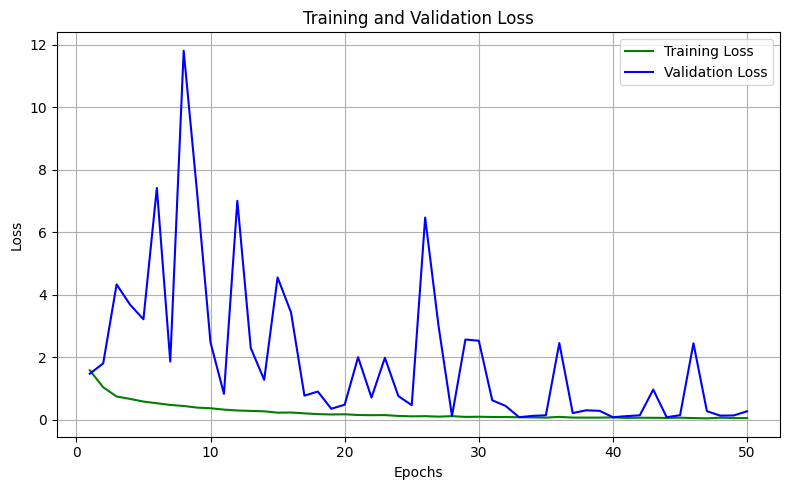

In [54]:
# Extract loss values
loss_train = history.history['loss']
loss_val = history.history['val_loss']

# Use the correct range based on actual number of epochs
epochs = range(1, len(loss_train) + 1)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


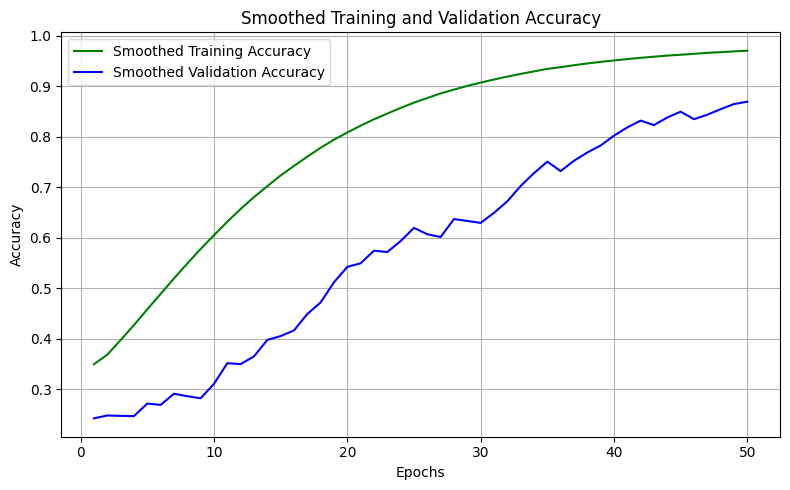

In [50]:
def smooth_curve(points, factor=0.9):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

plt.figure(figsize=(8, 5))
plt.plot(epochs, smooth_curve(acc_train), 'g', label='Smoothed Training Accuracy')
plt.plot(epochs, smooth_curve(acc_val), 'b', label='Smoothed Validation Accuracy')
plt.title('Smoothed Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
# After training your model…
model.save('my_model.keras')  


In [60]:
print("Hhf")

Hhf


80/80 [==============================] - 2s 15ms/step


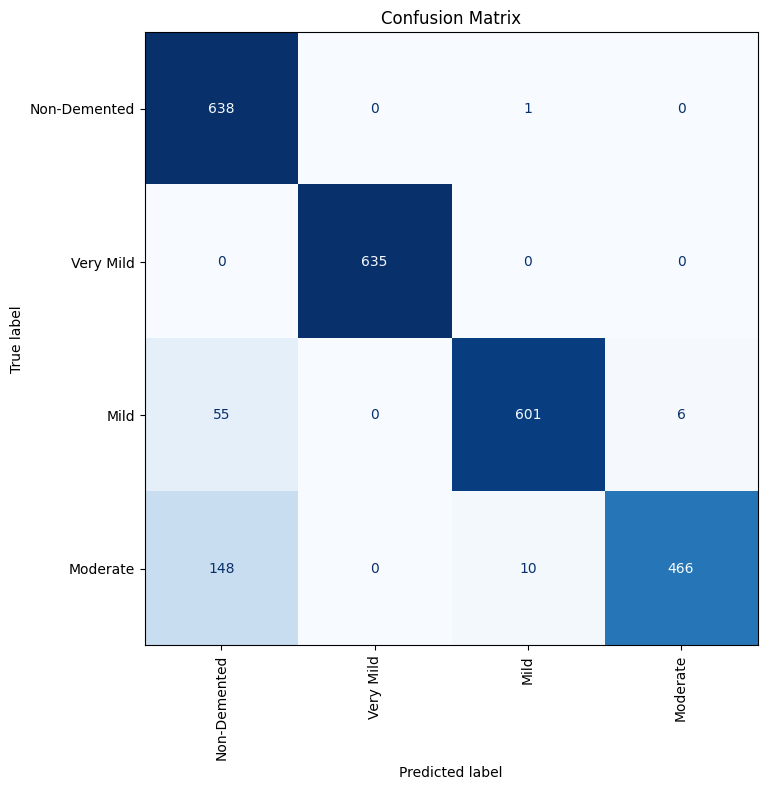

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check that test_data, test_labels, and model exist
if not all(name in globals() for name in ('test_data', 'test_labels', 'model')):
    print("Please ensure you've run the cells that define 'test_data', 'test_labels', and your trained 'model'.")
else:
    # Get true labels (handles both one-hot and integer formats)
    if hasattr(test_labels, 'ndim') and test_labels.ndim == 2:
        y_true = np.argmax(test_labels, axis=1)
    else:
        y_true = test_labels

    # Get model's predicted labels
    y_proba = model.predict(test_data)
    y_pred = np.argmax(y_proba, axis=1)

    # Define class names for the plot
    class_names = ['Non-Demented', 'Very Mild', 'Mild', 'Moderate']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()



--- ROC Curve and AUC ---


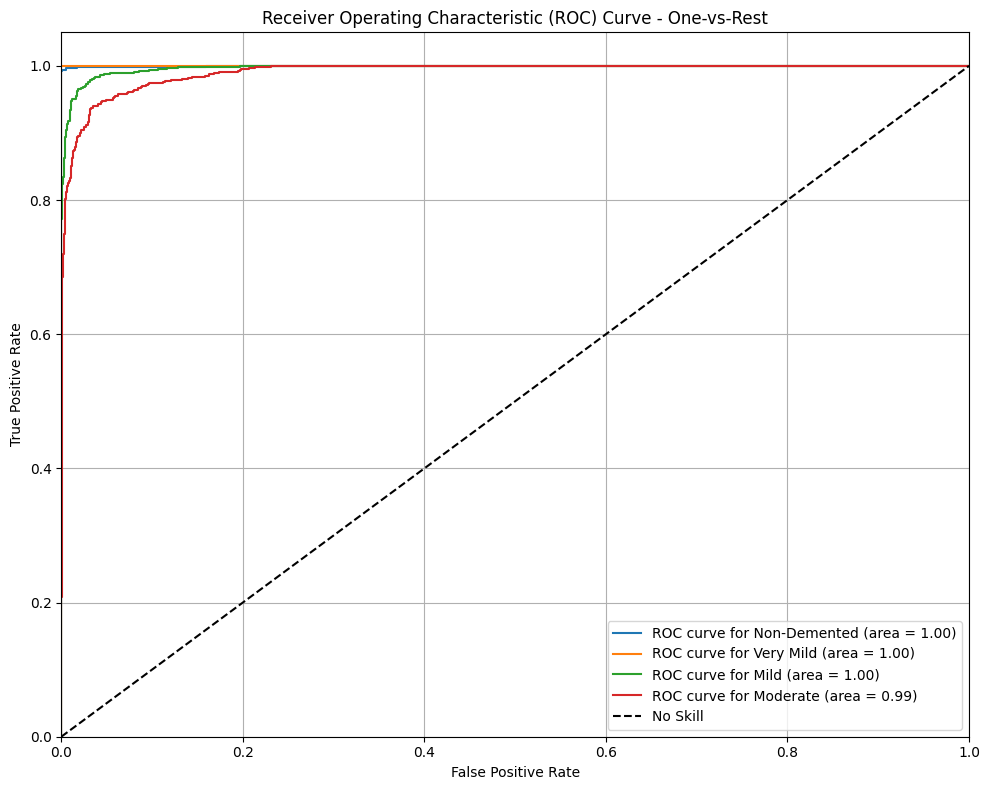

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Assuming you have these variables from your model's evaluation
# For demonstration purposes, let's assume they are already set up:
# y_true = test_labels       # Your actual labels (e.g., [0, 1, 2, 3, ...])
# y_proba = model.predict(test_data) # Your model's predicted probabilities (e.g., [[0.1, 0.2, 0.3, 0.4], ...])

# Define class names, ensure they match your dataset's classes
class_names = ['Non-Demented', 'Very Mild', 'Mild', 'Moderate']

# --- Area Under the Curve (AUC) and ROC Curve ---
print("\n--- ROC Curve and AUC ---")

# Binarize the labels for ROC curve calculation (one-vs-rest approach for multi-class)
lb = LabelBinarizer()
y_true_binarized = lb.fit_transform(y_true)
y_proba_adjusted = y_proba # Assuming y_proba is already in the correct format for multi-class

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_proba_adjusted[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, if you need a single AUC score for the entire multi-class problem,
# you might consider macro or micro averaging, or a weighted average.
# For simplicity, we are plotting individual ROC curves and AUCs here.

In [69]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have these variables from your model's evaluation
# For demonstration purposes, let's assume they are already set up:
# y_true = test_labels  # Your actual labels (e.g., [0, 1, 2, 3, ...])
# y_pred = np.argmax(model.predict(test_data), axis=1) # Your model's predicted class labels

# Define class names, ensure they match your dataset's classes
class_names = ['Non-Demented', 'Very Mild', 'Mild', 'Moderate']

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))


--- Classification Report ---
              precision    recall  f1-score   support

Non-Demented       0.76      1.00      0.86       639
   Very Mild       1.00      1.00      1.00       635
        Mild       0.98      0.91      0.94       662
    Moderate       0.99      0.75      0.85       624

    accuracy                           0.91      2560
   macro avg       0.93      0.91      0.91      2560
weighted avg       0.93      0.91      0.91      2560

